<a href="https://colab.research.google.com/github/btkcodedev/designproject/blob/main/scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

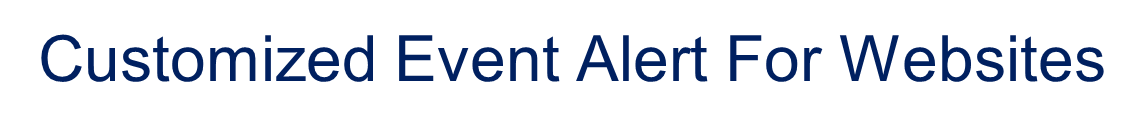

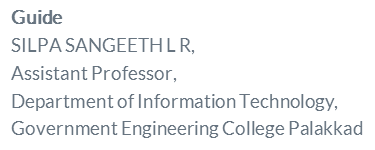


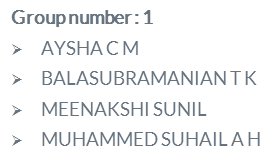

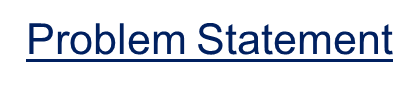
*   To build an alert system that continuously monitors and scrapes the events from websites, which then pushes it through some medium for users

# Algorithm


1. Importing all the requirements<br>
2. Get details from spreadsheet
3. Connecting the website with scraper<br>
4. Read saved csv file for old notifications<br>
5. Scrap the new notification and update the csv<br>
6. If there are new notifications, then send email<br>

# Code

In [ ]:
#Importing all the requirements
import requests                               #Helps to send HTTP request(connections)
from urllib.request import urlopen as ureq    #Helps to get connected with Specified URL's
from bs4 import BeautifulSoup as soup         #Helps to extract webpages using HTML Parser function
import smtplib,ssl                            #Helps to send out mails using SMTP
import io                                     #Helps tp encode the characters into specified format
import csv                                    #Helps to read csv file
from email.mime.text import MIMEText          #Email Decoration & Partitioning
from email.mime.multipart import MIMEMultipart
from google.colab import auth                 #Take authentication credentials
auth.authenticate_user()
import gspread                                #Helps with accessing spreadsheets
from oauth2client.client import GoogleCredentials

#Get Details from spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('Test(Responses)').sheet1
rows = worksheet.get_all_values()             #get_all_values gives a list of rows.
df=rows[1:]                                   #Take Email only
rec=[]
def Extract(lst): 
    return [item[1] for item in lst] 
rec=Extract(df)                               #Extracting the receivers to rec
 
filename='drive/MyDrive/clgscrap.csv'         #Results Storage
#Reading the old csv for previous notification
checker=[]
try:
  with open(filename,"r+",encoding="utf-16") as r:
    reader = csv.reader(r, delimiter="\n")
    for i,line in enumerate(reader):
        checker=checker+[line]                #Take the read lines into a list called checker
except Exception as e:
  err=e
 
#Connecting the website with scraper
myurl= 'http://gecskp.ac.in'                  #provide the required URL
ucli= ureq(myurl)                             #Connect to webpage using URLLIB
page_html = ucli.read()                       #reads the webpage and transfers to a variable
ucli.close()                                  #We should close the connection as the webpage can contain timeout
 
page_soup = soup(page_html,"html.parser")     #Get the html part using the html.parser function of beautifulsoup library
#Specify the tag where brief of needed data can be extracted
containers = page_soup.findAll("a",{"style":"font-weight: 600; font-style: normal;"},{"href"})

#Scraping and updating the csv
with open(filename,"w+",encoding="utf-16") as f:  #External encoding to support multiple languages
    headers= "NEWS,LINK\n"
    f.write(headers)                              #specifying headers
    lis=[]
    mailbody=[]
    maillink=[]
    q=0 
    i=0
    for container in containers:
        link = containers[q].get('href')         #Get the exact location inside the brief location
        news = containers[q].text                #Get the text inside the tags using .text function
        orglink = ("http://gecskp.ac.in/"+link)  #Get the link
        result = link.startswith('http')
        if(result==1):
          orglink = link                         #Get the link
        if(q==1):                                #For the checking of new update
            checkernew=news+" "+orglink.replace(" ", "%20")          #Take new update to a variable checkernew
        final="News: " + news+ "\n"
        linker="Link: " + orglink.replace(" ", "%20") + "\n"
        mailbody=mailbody+[final]
        maillink=maillink+[orglink.replace(" ", "%20")]
        lis=lis+[final+linker] 
        f.write(news.replace(",","|")+" "+orglink.replace(" ","%20") + "\n")  #Replacing extra symbols in messages to clean format 
        q=q+1
        i=i+1
f.close()                                             #finally close the file to open it with interface

print("Latest\n",lis[1])                              #Gives latest nofication
print("All\n",' '.join(lis))                          #Gives all the notification
try:
  c=checker[2]                                        #Notification from stored csv
  flag=1
except Exception as e:
  error=e
  flag=0

print("Previous stored notification: "+str(checker[2]))
print("Present scraped notification: "+str("['"+checkernew+"']"))

if flag==1:
  if(str(checker[2])!=str("['"+checkernew+"']")):     #Check new update with old update
                                                      #username : testscrapmailer@gmail.com pass: testscraper
      smtp_server = "smtp.gmail.com"                  #using python smtp gmail client
      sender="testscrapmailer@gmail.com"              #sender
      appkey="testscraper"                            #password
      receiver=rec                                    #receiver
      context = ssl.create_default_context()          #Creating a secure socket connection
  
      message = MIMEMultipart("alternative")          #Using Multiple Parts for supporting simple text and html
      message["Subject"] = "GEC ALERT"                #Subject
      message["From"] = sender                        #Sender
      message["To"] = ", ".join(receiver)             #Reciever
  
      # Create the plain-text and HTML version of message
      text = """\
      GEC SCRAPER: 
      Dear Student,
      The website has been updated by a new notification as follows
      """ +str(mailbody[1])+str(maillink[1])+""".
      Previous Notification: """ +str(mailbody[2])+str(maillink[2])+"""
      """
  
      html = """\
      <html>
        <body>
          <h4 style="text-align:center;">GEC SCRAPER</h4>
          <p>
            <h5><i>Dear Student,</i></h5>
            <br>The website has been updated by a new notification as follows,<br>
            """ +str(mailbody[1])+ """ <a href="""+str(maillink[1])+""">Details</a>
            <br> 
            <br>Previous Notification:<br>
            """ +str(mailbody[2])+ """ <a href="""+str(maillink[2])+""">Details</a>
          </p>
          <br>
          <h4>Thank You.</h4>
          <br>
        </body>
      </html>
      """

      # Turn these into plain/html MIMEText objects
      part1 = MIMEText(text, "plain")
      part2 = MIMEText(html, "html")
  
      # Add HTML/plain-text parts to MIMEMultipart message
      # The email client will try to render the last part first
      message.attach(part1)
      message.attach(part2)
  
      try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as conn:   #Connecting to SMTP
            conn.login(sender, appkey)                                           #Account login           
            if not rec:                  
               print("\nNo Senders to send")
            else:
              for item in rec:                                                 #For everyone in the spreadsheet
                  conn.sendmail(
                      sender, item, message.as_string()                          #Mail Sent
                  )
              print("\nMail send successfully!")
      except Exception as e:
        conn.quit()
  else:
    print("\nNo New Updates")

Latest
 News: URGENT: 2021 ഇൽ കോഴ്സ് പൂർത്തിയാക്കുന്ന എല്ലാവരുടെയും സർട്ടിഫിക്കറ്റ് വെരിഫിക്കേഷൻ ചെയ്യുന്നതിനായി അറ്റെസ്റ് ചെയ്ത സർട്ടിഫിക്കറ്റ് കോപ്പികൾ KTU എത്തിക്കാൻ ആവശ്യപ്പെട്ടിട്ടുണ്ട്. അതിനാൽ ആയത്  11/02/2021 നു അകം സി1 സെക്ഷനിൽ എത്തിക്കേണ്ടത് ആണ്  
Link: http://gecskp.ac.in/pdf/news/verification.pdf

All
 News:  Contact class works started wef. 04/01/2021. Contact concerned department for details.  
Link: http://gecskp.ac.in/admission.php
 News: URGENT: 2021 ഇൽ കോഴ്സ് പൂർത്തിയാക്കുന്ന എല്ലാവരുടെയും സർട്ടിഫിക്കറ്റ് വെരിഫിക്കേഷൻ ചെയ്യുന്നതിനായി അറ്റെസ്റ് ചെയ്ത സർട്ടിഫിക്കറ്റ് കോപ്പികൾ KTU എത്തിക്കാൻ ആവശ്യപ്പെട്ടിട്ടുണ്ട്. അതിനാൽ ആയത്  11/02/2021 നു അകം സി1 സെക്ഷനിൽ എത്തിക്കേണ്ടത് ആണ്  
Link: http://gecskp.ac.in/pdf/news/verification.pdf
 News: First year B.Tech students who seek temporary accomodation in MH and LH during the period of contact classes ( 01/03/2021 to 13/03/2021) may  fill the Google Form by clicking here on or before 10/02/2021 , 10 PM.
Link: https://forms.gle/i5T